Notebook dependencies: 
- sampling (dev)
- Visualization: plotly, seaborn, matplotlib
- Data processing: numpy, pandas

In [1]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Data processing
import pandas as pd
import numpy as np

# Time
from time import time

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------------------------------------------
# Default theme configurations§
# ----------------------------------------------------------------
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
matplotlib.rcParams.update({'errorbar.capsize': 4})

# Set default theme for seaborn plots
sns.set_style("whitegrid")
DEFAULT_PALETTE = sns.color_palette("tab10", n_colors=1)

# ----------------------------------------------------------------
# Visualizations
# ----------------------------------------------------------------
def barplot(values, stds, palette=DEFAULT_PALETTE, **kwargs):
    default_args = {"ecolor": "black", "alpha": 1}
    if kwargs:
        default_args.update(kwargs)
        
    n = len(values)
    index = np.arange(n)
    
    return sns.barplot(x=index, y=values, yerr=stds, palette=palette, **default_args)


def barplot_ncol(values, stds, titles, palette=DEFAULT_PALETTE, figsize=(10, 5), tick_freq=5, **kwargs):
    n = len(values)
    
    fig, axes = plt.subplots(1, n, sharey=True, figsize=figsize)
    
    for i in range(n):
        barplot(values[i], stds[i], ax=axes[i], palette=palette, **kwargs)
        axes[i].set_title(titles[i])
        axes[i].set_xticks(np.arange(len(values[i]))[::tick_freq])
    plt.show()
    
    
def sample_mean_std(array, width=2, stepsize=5):
    """Computes how the values converge to a mean and its std"""
    means, cis, ids = [], [], []
    
    for i in range(stepsize, len(array), stepsize):
        mean = array[:i].mean().item()
        means.append(mean)
        
        std = array[:i].std().item() / np.sqrt(i)
        cis.append((mean- width * std, mean+ width * std)) 
        ids.append(i)
    else:
        mean = array.mean().item()
        means.append(mean)
        std = array.std().item() / np.sqrt(i)
        cis.append((mean-width * std, mean+width * std))
        ids.append(len(array))
        
    return means, cis, ids


def plot_convergence_plots(ids, means, cis, labels, input_str, avoid_terms, title=None, figsize=(10,5)):
    plt.figure(figsize=figsize)
    
    for i in range(len(ids)):
        ax = sns.lineplot(x=ids[i], y=means[i], label=labels[i])
        ax.fill_between(ids[i], *zip(*cis[i]), alpha=0.5)

    if title is None:
        plt.title(f"$P(N_A(K) = 0 |\, H=$'{input_str}'$)$, where $A =$" + "{" + avoid_terms +"}")
    else:
        plt.title(title)
    plt.show()
    
    

## Setup

In [2]:
from sampling.importance_sampler import ImportanceSampler
from sampling.naive_sampler import NaiveSampler

# MODEL_NAME = "EleutherAI/gpt-neo-125M"
MODEL_NAME = "EleutherAI/gpt-neo-1.3B"

# Load the sampler (including model + tokenizer)
sampler_is = ImportanceSampler(MODEL_NAME, device="cuda")
sampler_mc = NaiveSampler(MODEL_NAME, device="cuda")

Importing classes for model EleutherAI/gpt-neo-1.3B
 -> <class 'transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer'>
 -> <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>
Vocabulary size: 50257
Pad token id: 50256


## sample_not_occur

In [3]:
NUM_SEQUENCES = 2560

estimate_not_occur_kwargs = {
    "input_str": "2 + 2 =",
    "avoid_terms": "0 0 1 2 3 4 5 6 7 8 9 10 12 -0 -1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -12 one two three four + - * / x y v z u f",
    
    # "input_str": "He is such a",
    # "avoid_terms": ". . , ! ?",
    
    # "input_str": "Hello! My name is",
    # "avoid_terms": ". . , ! ?",
    
    # "input_str": "It's not you, it's",
    # "avoid_terms": " me I not",
    
    # "input_str": "The movie was great!",
    # "avoid_terms": "positive",
    
    "num_sequences": NUM_SEQUENCES,
    "batch_size": 64, # 40 iterations
    "max_num_tokens": 50,
    "seed": 97163,
}

results_mc = sampler_mc.batch_estimate_not_occurring(**estimate_not_occur_kwargs) # FIXME; ERROR if NUM_SEQ % BATCH_SIZE != 0
results_is = sampler_is.batch_estimate_not_occurring(**estimate_not_occur_kwargs)

0it [00:01, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 23.69 GiB total capacity; 22.41 GiB already allocated; 11.88 MiB free; 22.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### convergence of the algorithm

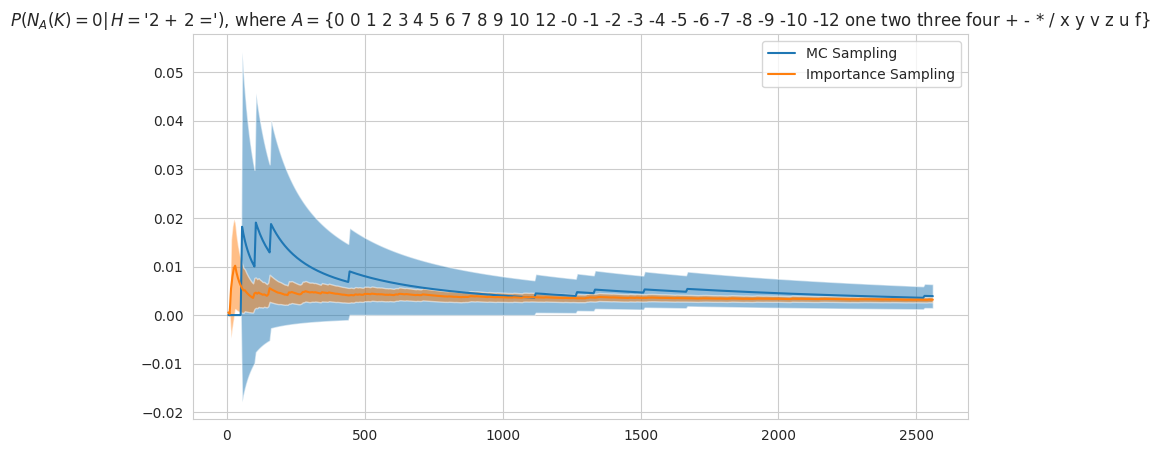

In [31]:
## convergence of the algorithm as a function of the number of samples
prob_of_occurring_at_least_once_IS = results_is.probs[-1]
prob_of_occurring_at_least_once_MC = results_mc.probs[-1]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_of_occurring_at_least_once_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_of_occurring_at_least_once_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=["MC Sampling", "Importance Sampling"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
)

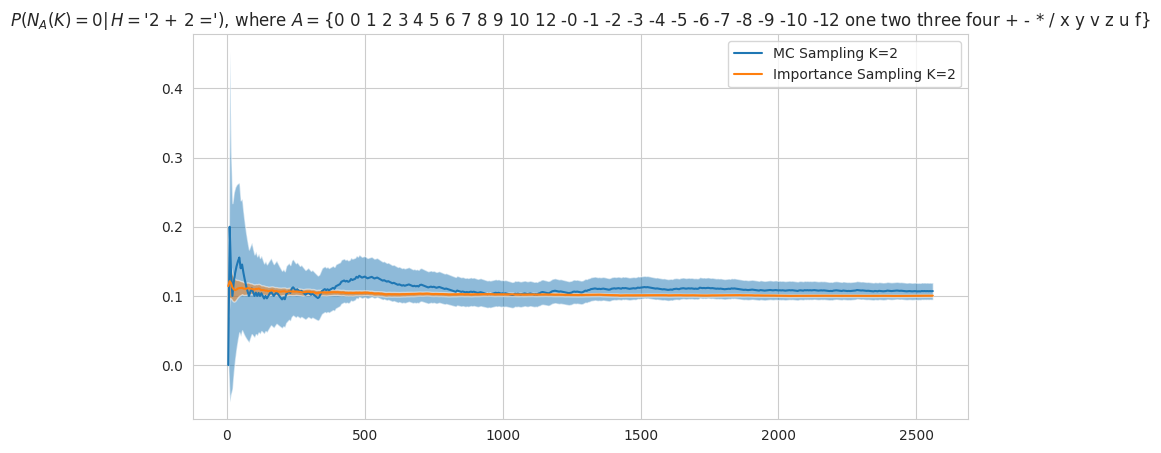

In [32]:
k = 2
## convergence of the algorithm as a function of the number of samples
prob_of_occurring_at_least_once_IS = results_is.probs[k]
prob_of_occurring_at_least_once_MC = results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_of_occurring_at_least_once_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_of_occurring_at_least_once_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
)

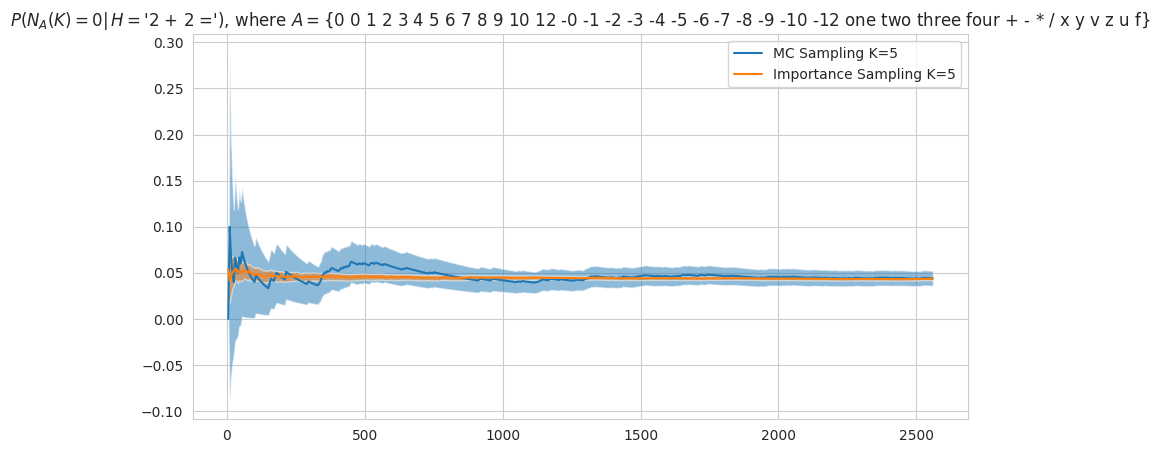

In [33]:
k = 5
## convergence of the algorithm as a function of the number of samples
prob_of_occurring_at_least_once_IS = results_is.probs[k]
prob_of_occurring_at_least_once_MC = results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_of_occurring_at_least_once_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_of_occurring_at_least_once_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
)

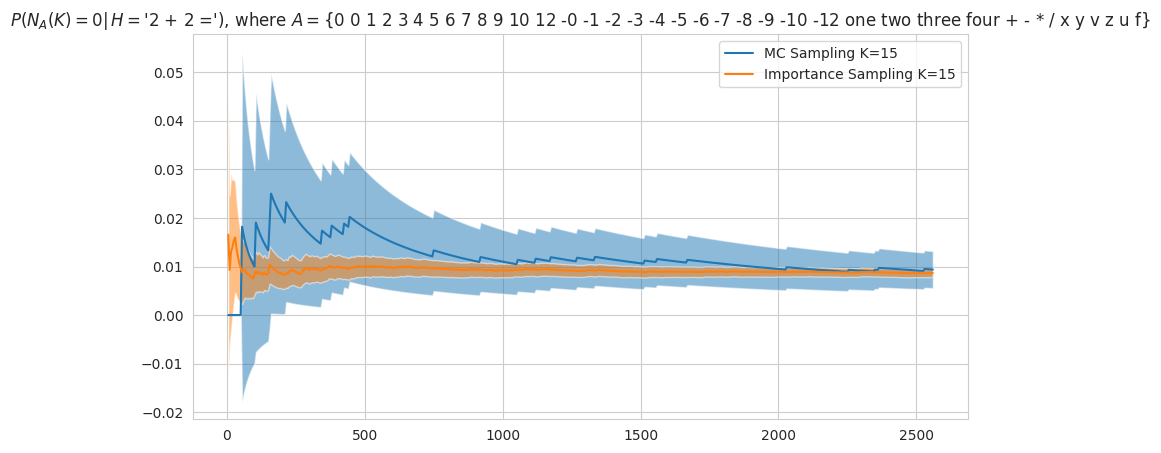

In [34]:
k = 15
## convergence of the algorithm as a function of the number of samples
prob_of_occurring_at_least_once_IS = results_is.probs[k]
prob_of_occurring_at_least_once_MC = results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_of_occurring_at_least_once_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_of_occurring_at_least_once_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
)

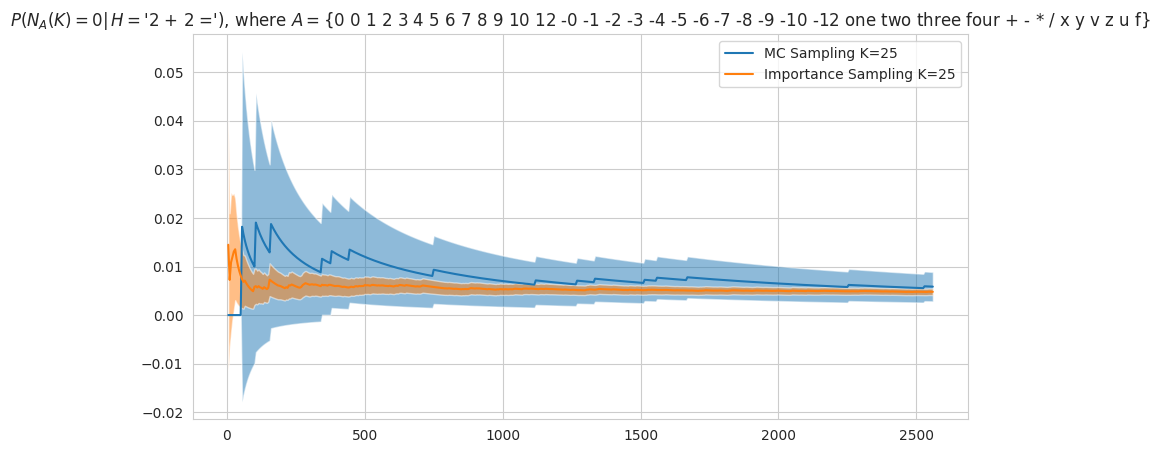

In [35]:
k = 25
## convergence of the algorithm as a function of the number of samples
prob_of_occurring_at_least_once_IS = results_is.probs[k]
prob_of_occurring_at_least_once_MC = results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_of_occurring_at_least_once_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_of_occurring_at_least_once_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
)

### compute confidence interval per timestep

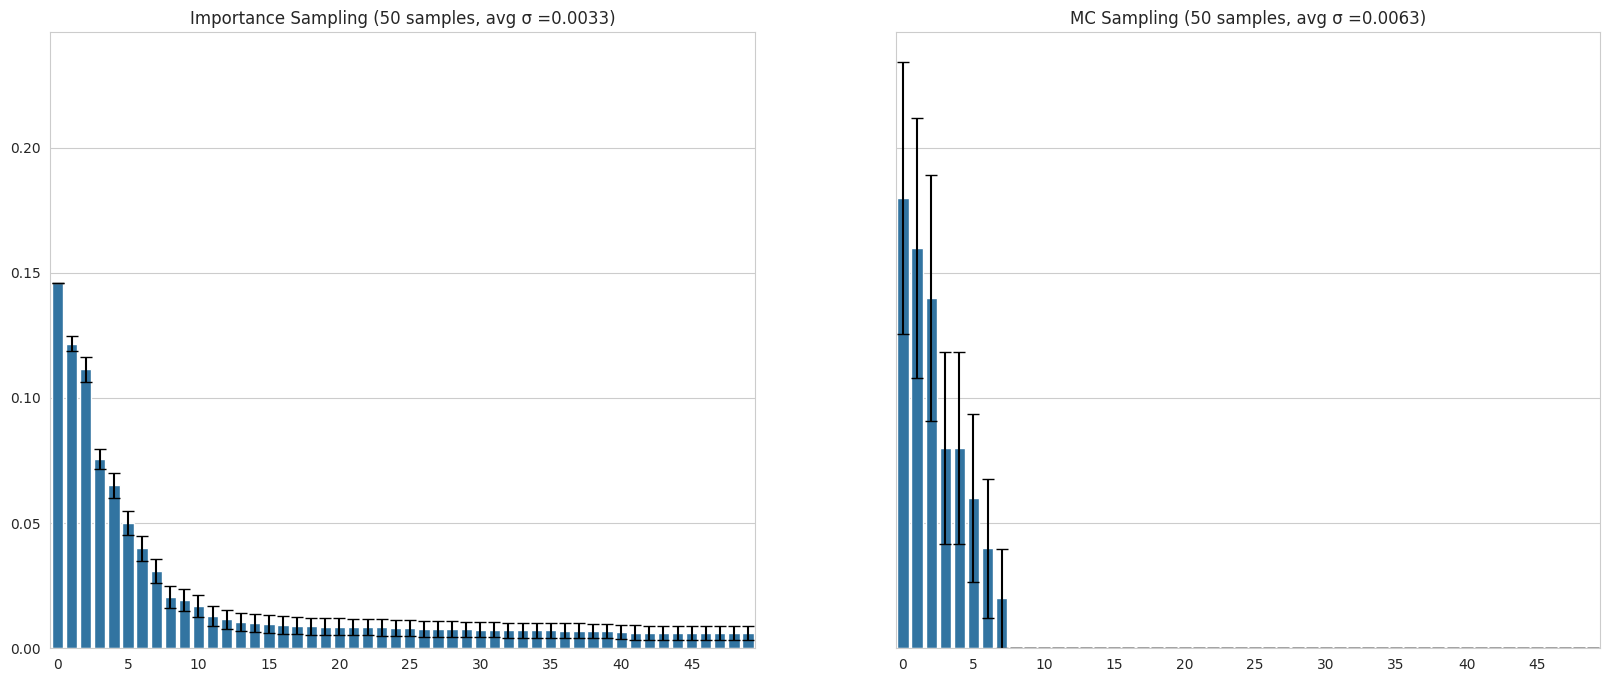

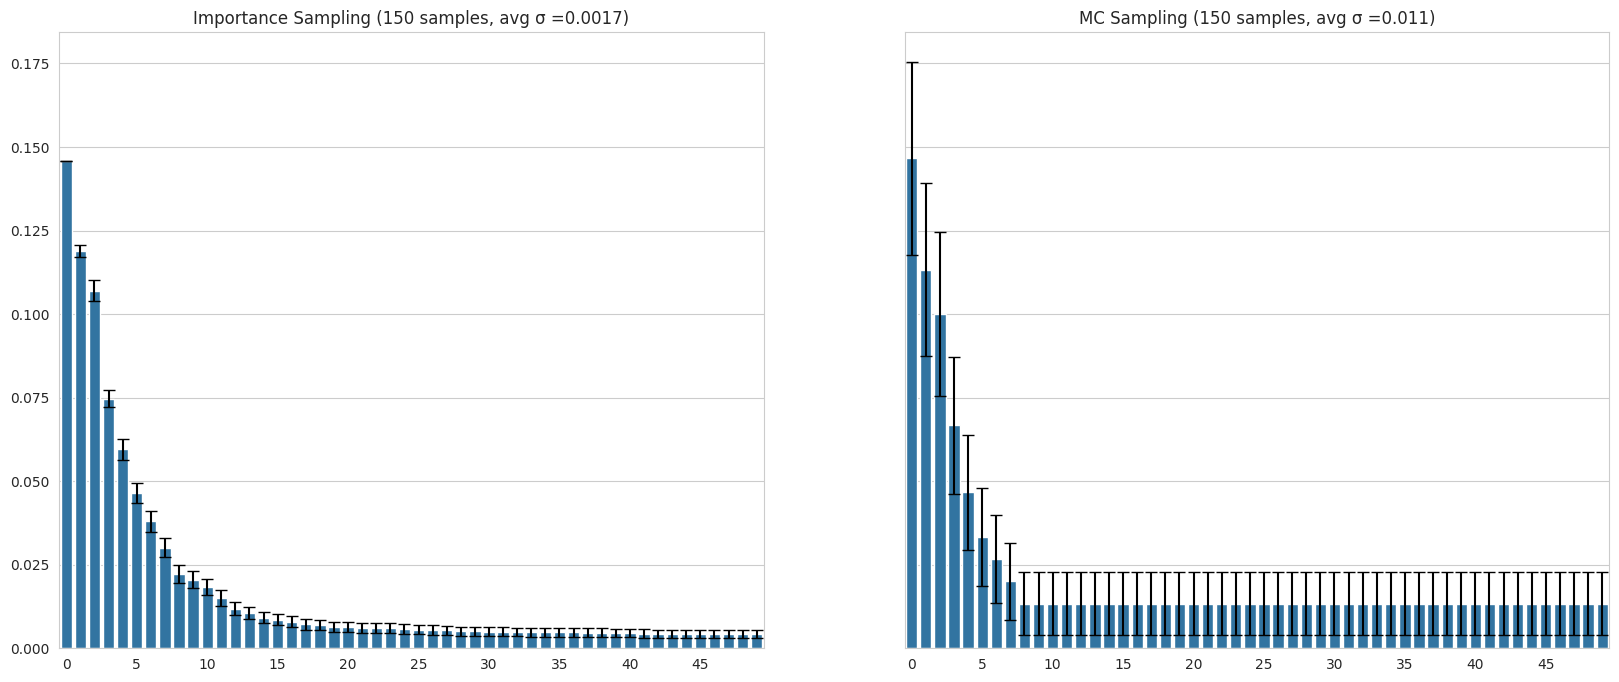

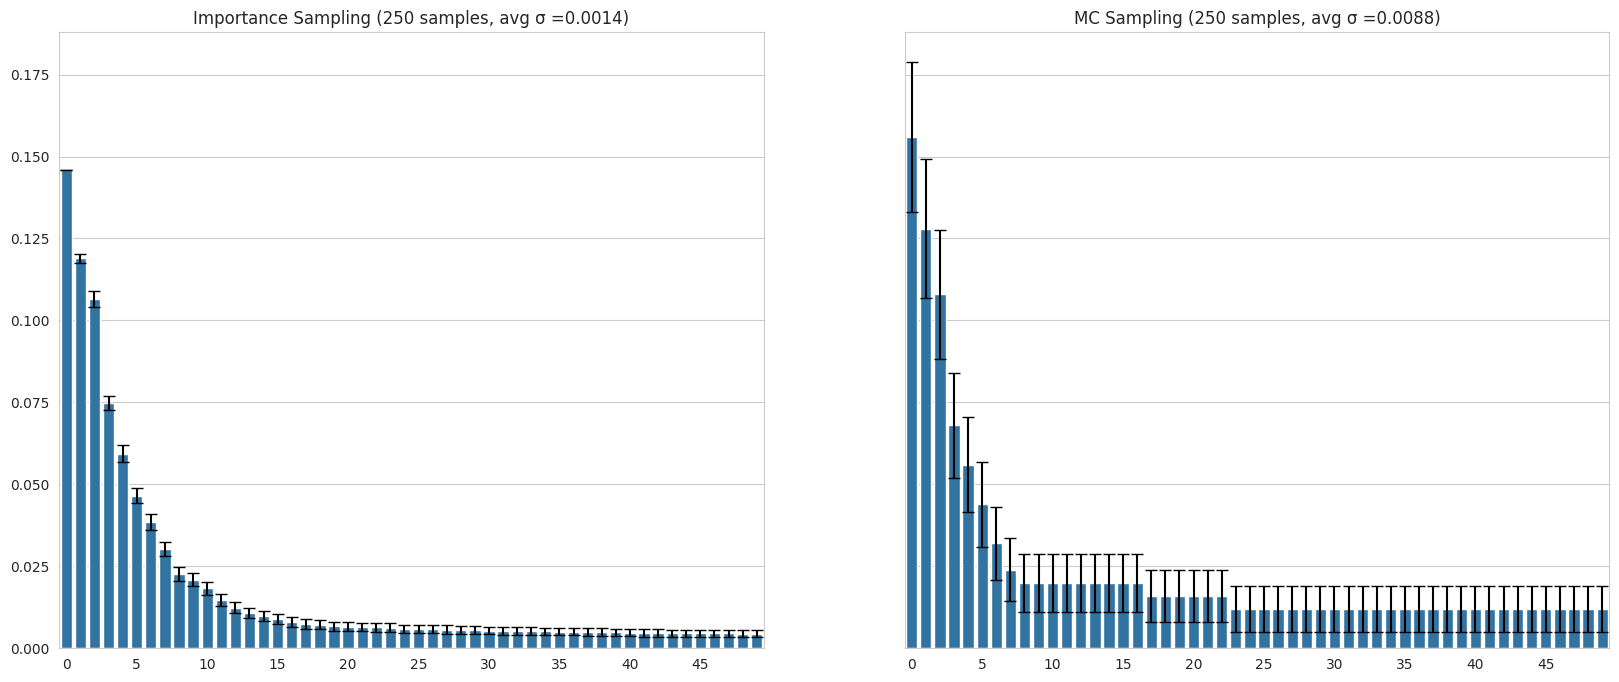

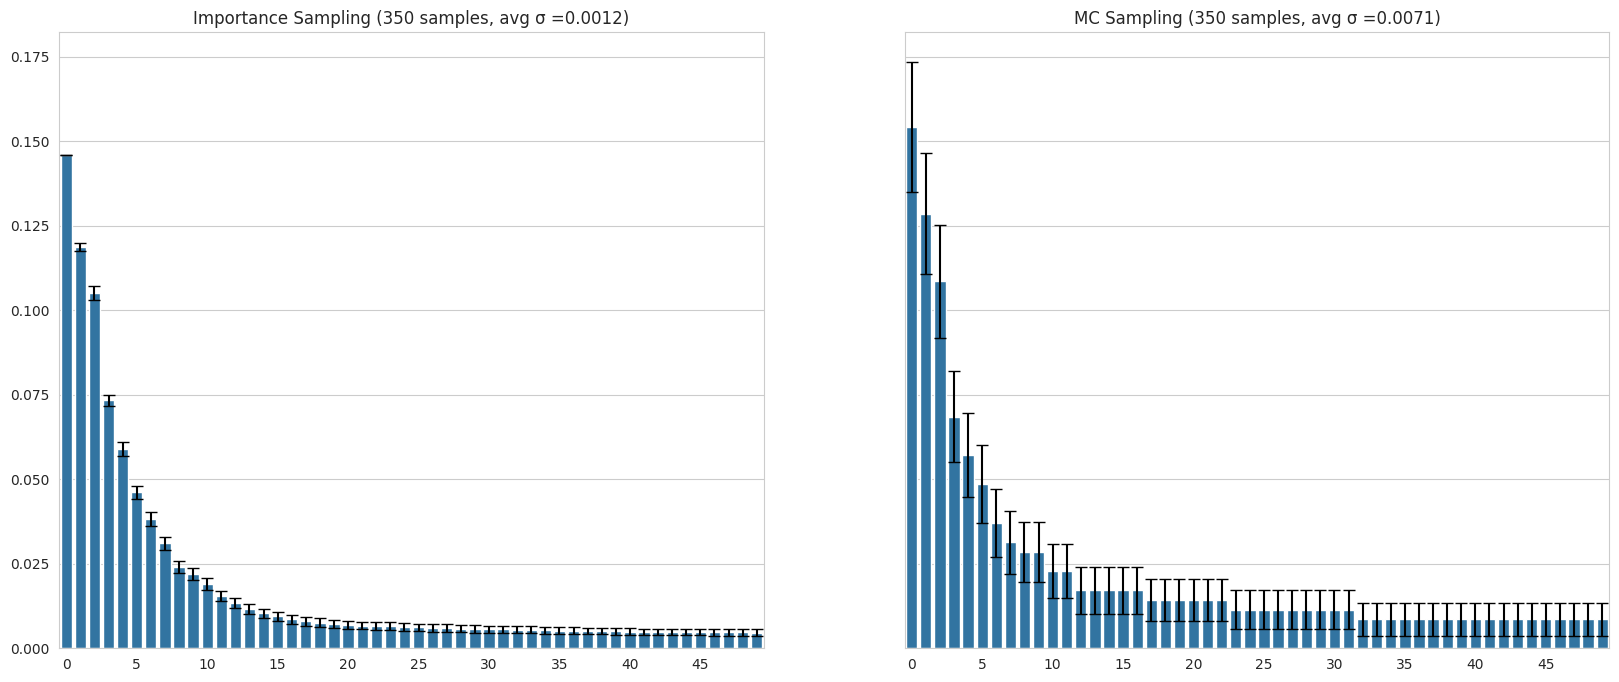

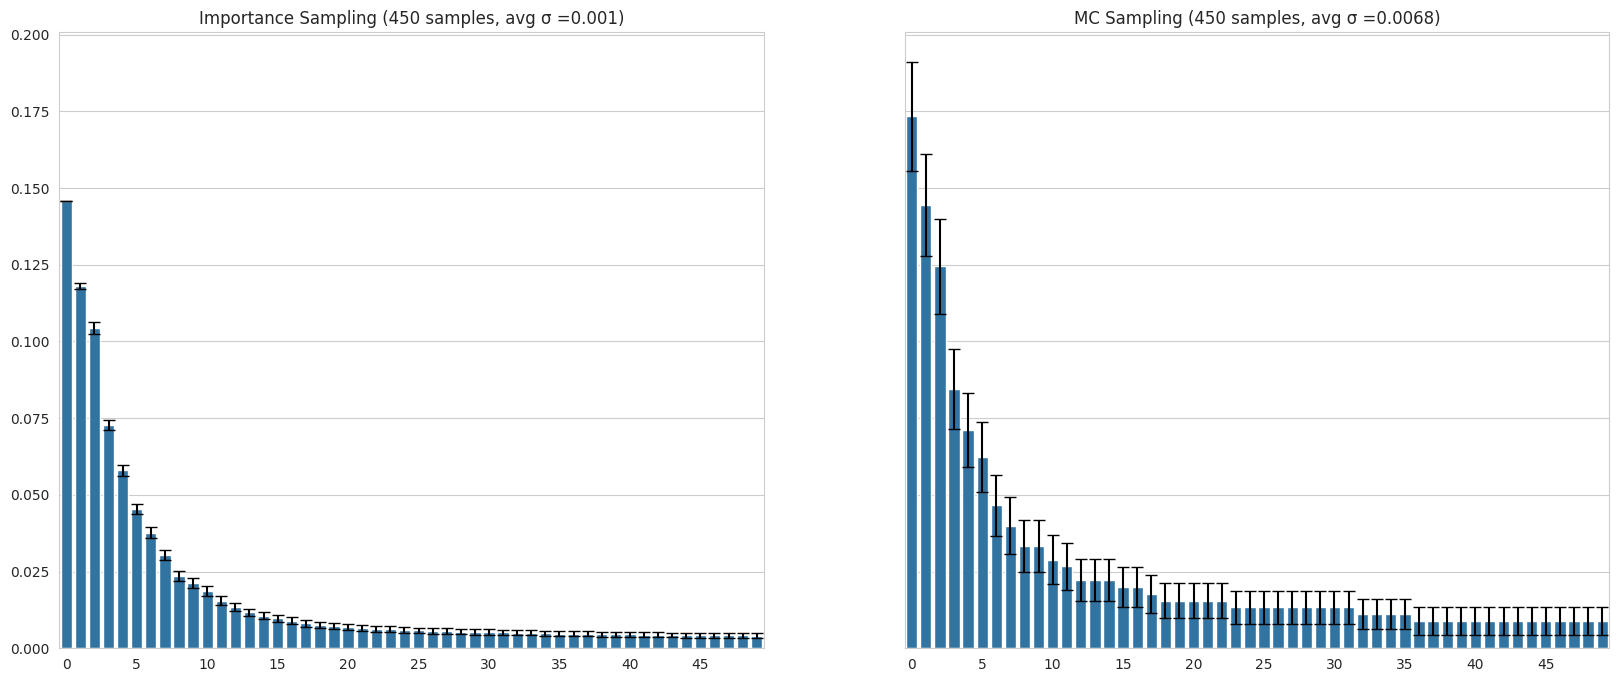

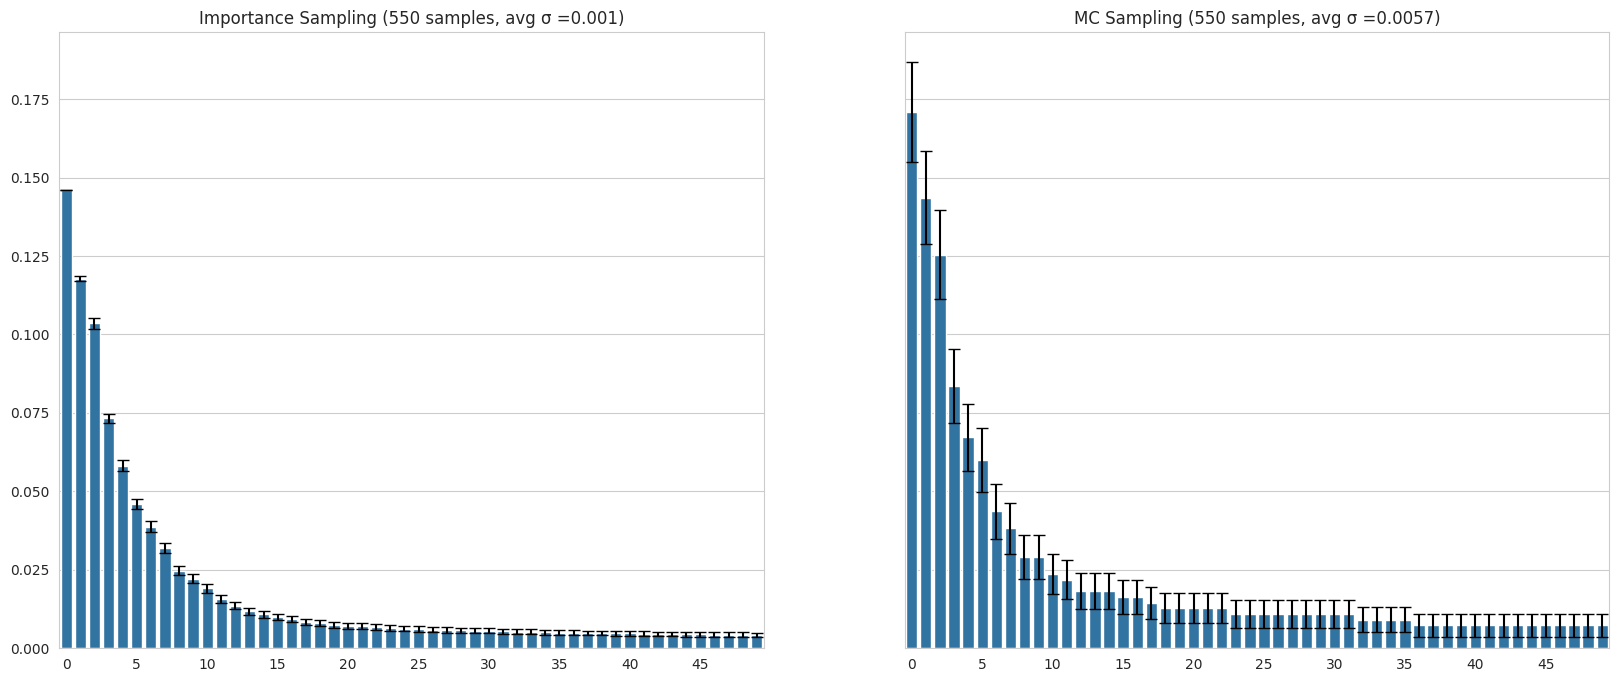

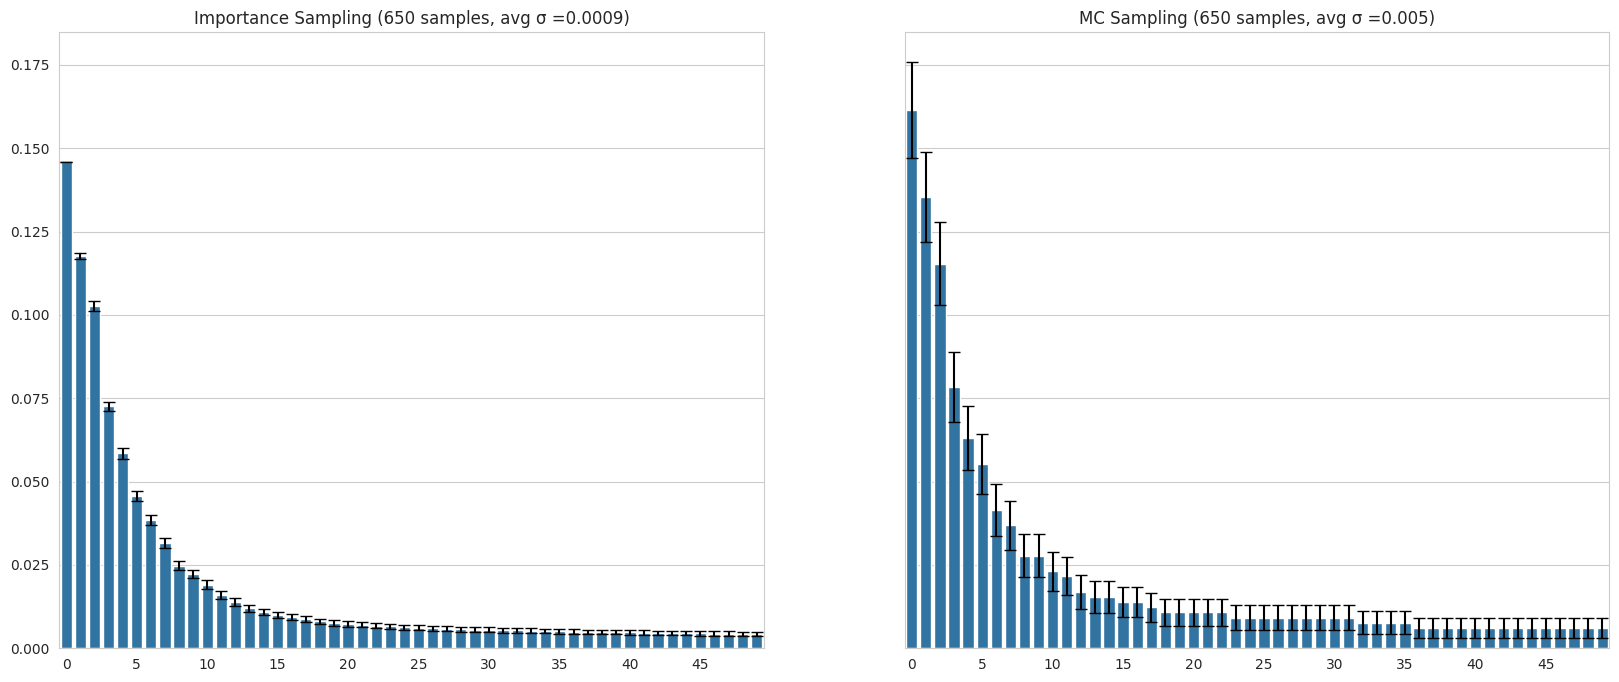

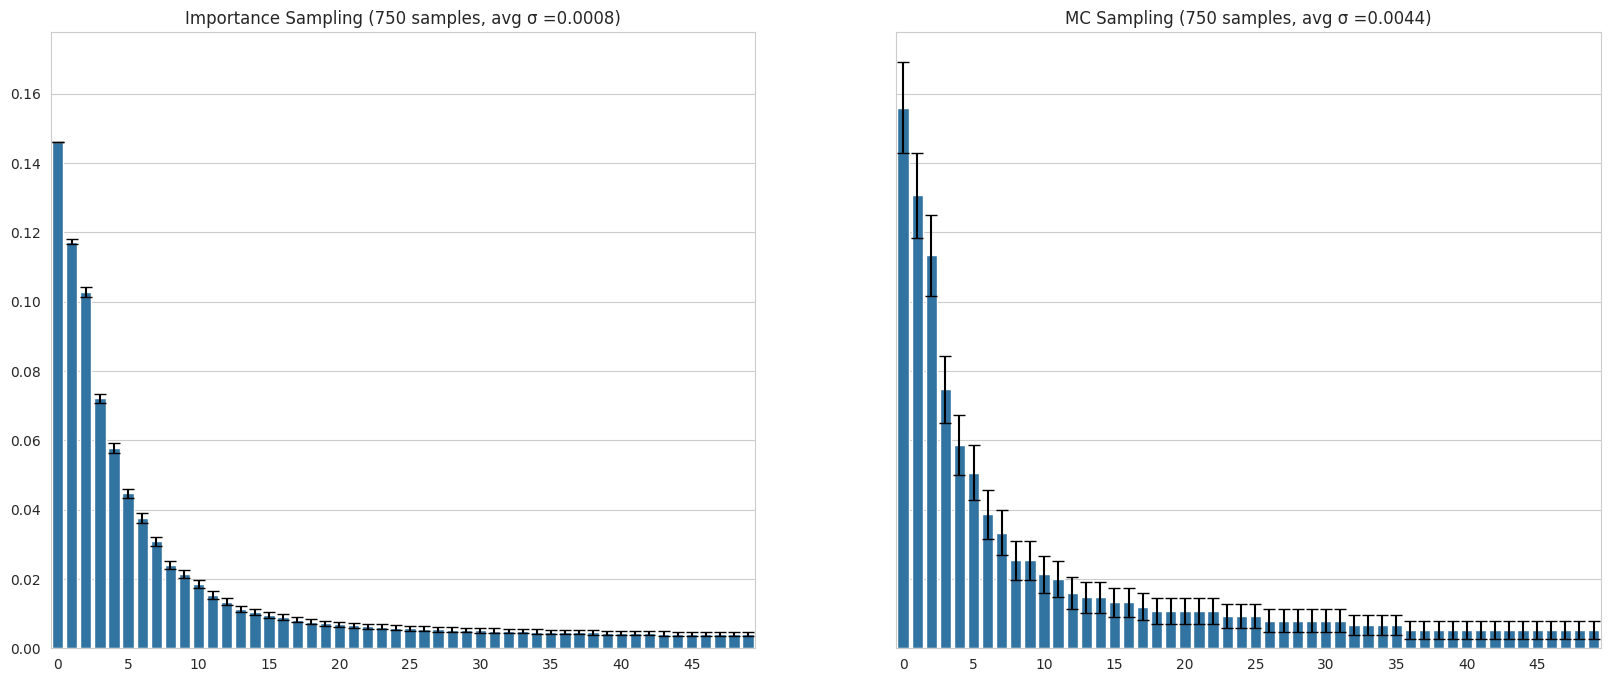

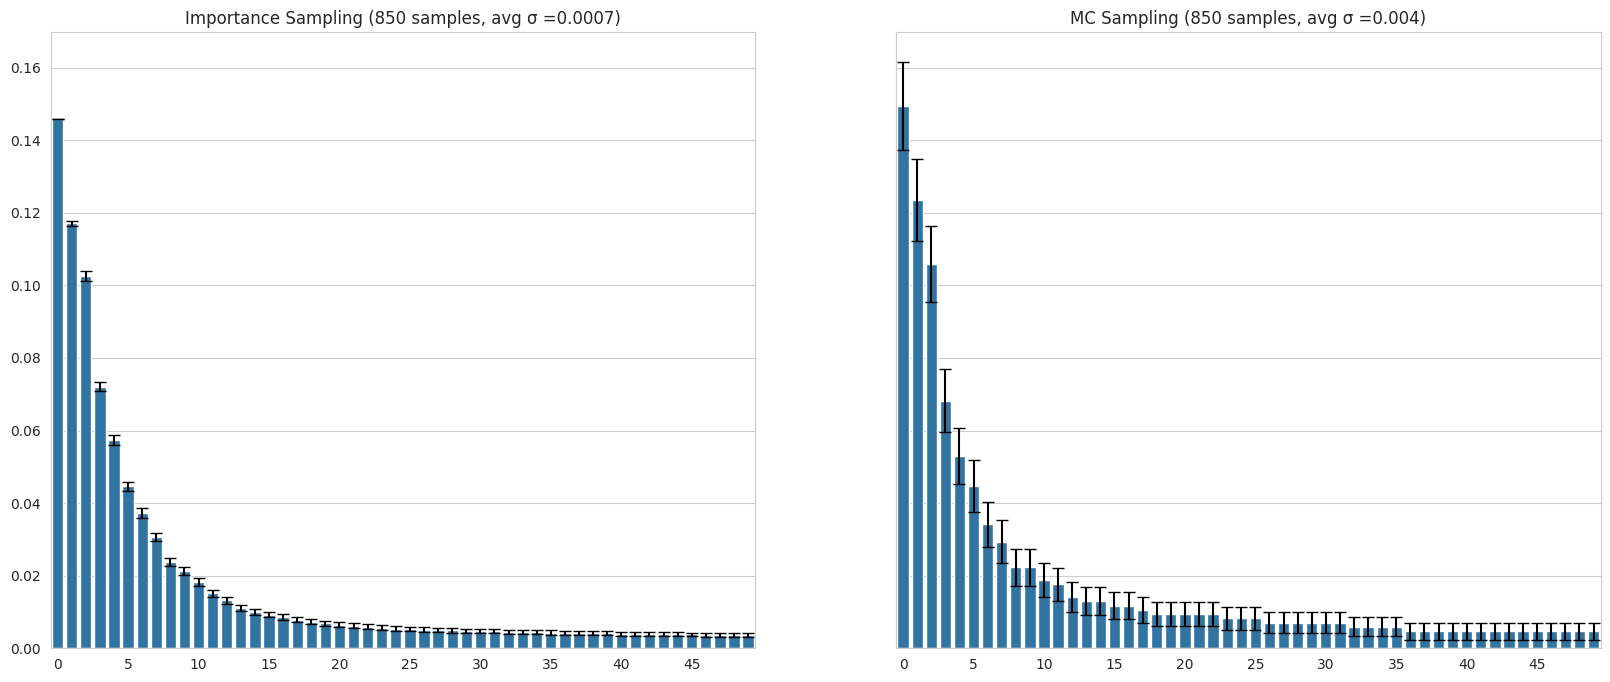

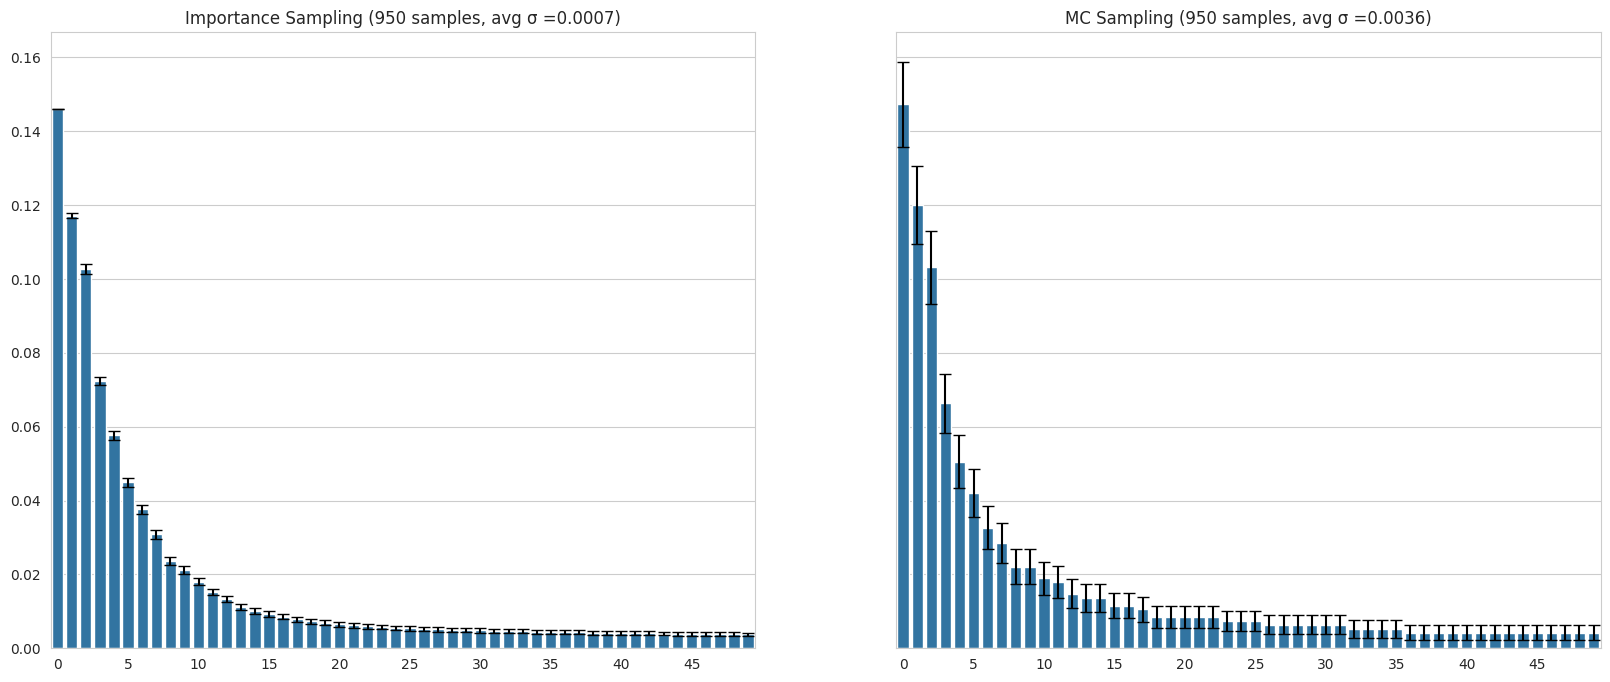

In [36]:
for i in range(50, 1000, 100):
    is_probs = [p[:i,:] for p in results_is.probs]
    mc_probs = [p[:i,:] for p in results_mc.probs]

    is_mean, is_std = sampler_is.compute_confidence_intervals(is_probs, width=2)
    mc_mean, mc_std = sampler_mc.compute_confidence_intervals(mc_probs, width=2)
    
    
    barplot_ncol(
        values=[is_mean, mc_mean],
        stds=[is_std, mc_std],
        titles=[f"Importance Sampling ({i} samples, avg σ ={round(np.mean(is_std), 4)})", f"MC Sampling ({i} samples, avg σ ={round(np.mean(mc_std), 4)})"],
        figsize=(20, 8)
    )

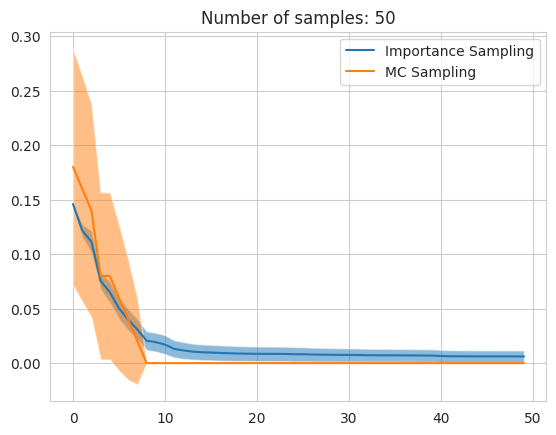

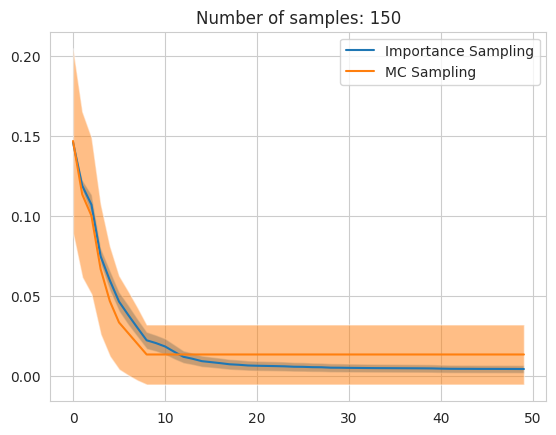

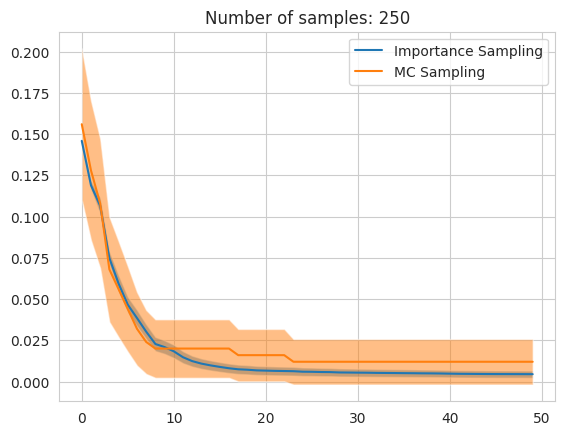

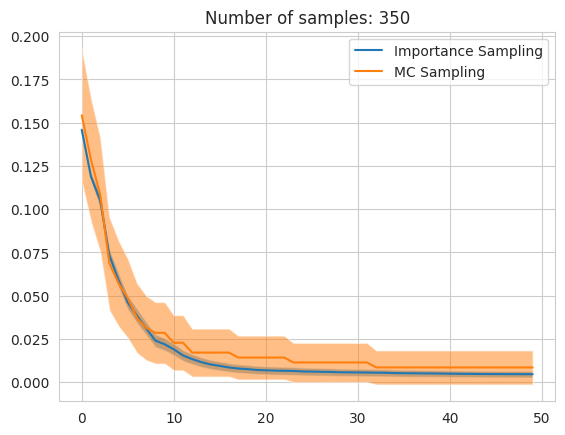

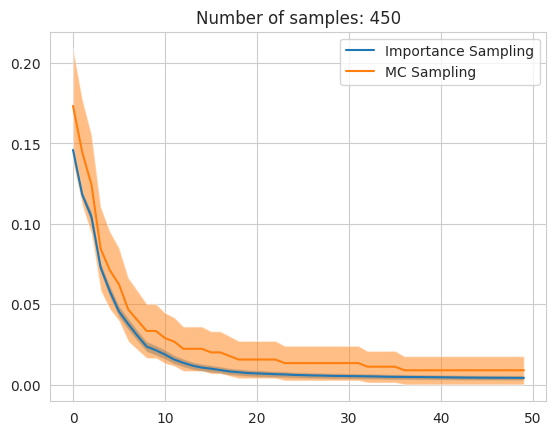

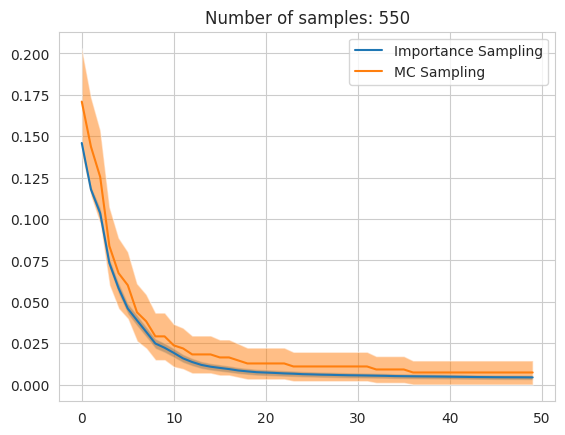

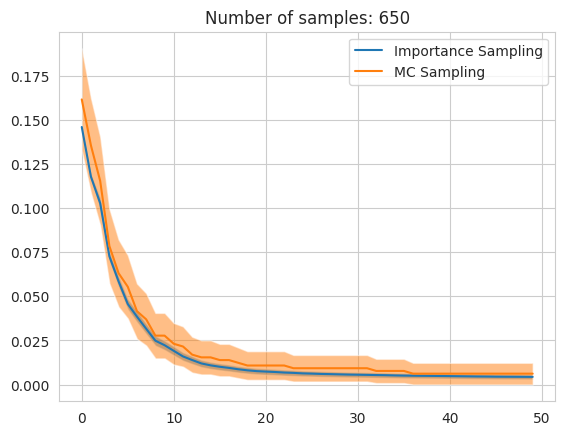

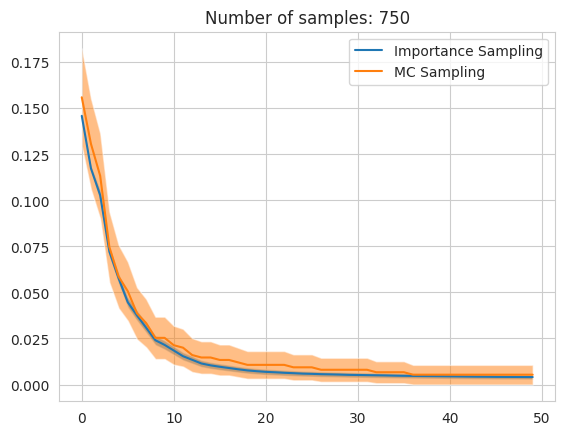

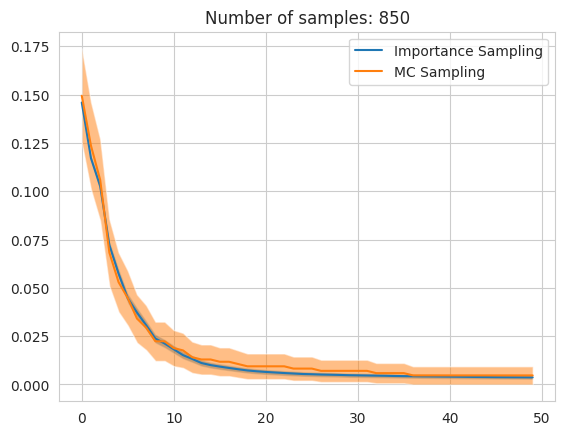

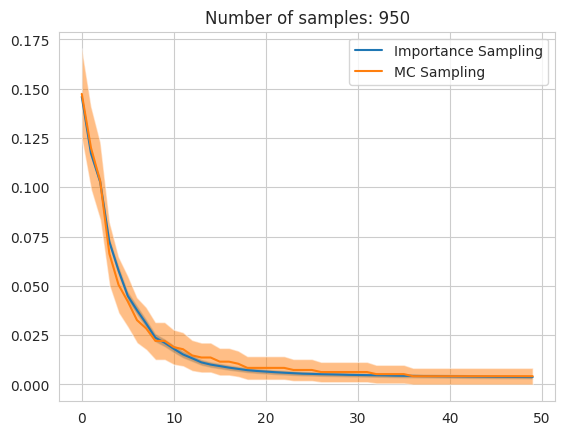

In [37]:
width = 2

for i in range(50, 1000, 100):
    is_probs = [p[:i,:] for p in results_is.probs]
    mc_probs = [p[:i,:] for p in results_mc.probs]

    is_mean, is_std = sampler_is.compute_confidence_intervals(is_probs, width=2)
    mc_mean, mc_std = sampler_mc.compute_confidence_intervals(mc_probs, width=2)
    
    ax = sns.lineplot(x=np.arange(len(is_mean)), y=is_mean, label="Importance Sampling")
    cis = [(mean - width * std, mean + width * std) for mean, std in zip(is_mean, is_std)]
    ax.fill_between(np.arange(len(is_mean)), *zip(*cis), alpha=0.5)

    ax = sns.lineplot(x=np.arange(len(mc_mean)), y=mc_mean, label="MC Sampling")
    cis = [(mean - width * std, mean + width * std) for mean, std in zip(mc_mean, mc_std)]
    ax.fill_between(np.arange(len(mc_mean)), *zip(*cis), alpha=0.5)

    
    plt.title(f"Number of samples: {i}")
    plt.show()

## sample_marginals

In [4]:
NUM_SEQUENCES = 2560

estimate_marginals_kwargs = {
    # "input_str": "He is such a",
    # "terms": ". . , ! ?",
    # "input_str": "Once upon a time",
    # "terms": " was were",
    # "input_str": None,
    # "terms": ". , ! ?",
    # "terms": "0 1 2 3 4 5 6 7 8 9",

    "input_str": "2 + 2 =",
    "terms": " 0 1 2 3 4 5 6 7 8 9 10 12 -0 -1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -12 one two three four + - * / .",
    "num_sequences": NUM_SEQUENCES,
    "batch_size": 64,
    "max_num_tokens": 50,
    "seed": 97163,
    "add_first_word_tokens": True,
}

marginals_results_mc = sampler_mc.batch_estimate_marginals(**estimate_marginals_kwargs)
marginals_results_is = sampler_is.batch_estimate_marginals(**estimate_marginals_kwargs)

0it [00:00, ?it/s]


TypeError: an integer is required (got type list)

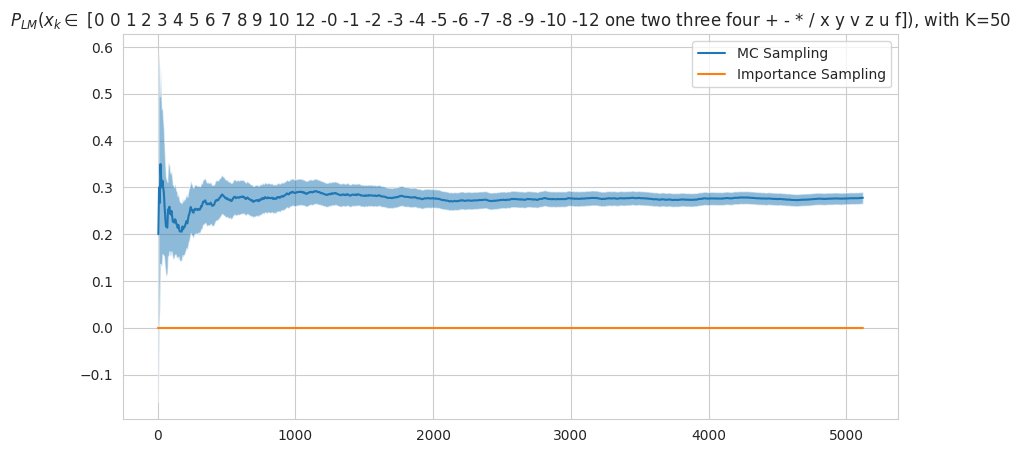

In [55]:
k = len(marginals_results_is.probs)
## convergence of the algorithm as a function of the number of samples
prob_marginals_IS = marginals_results_is.probs[k-1]
prob_marginals_MC = marginals_results_mc.probs[k-1]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_marginals_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_marginals_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=["MC Sampling", "Importance Sampling"],
    input_str=estimate_marginals_kwargs["input_str"],
    avoid_terms=estimate_marginals_kwargs["terms"],
    title="$P_{LM}(x_k \in$ [" + estimate_marginals_kwargs["terms"] +f"]$)$, with K={k}"
)

In [56]:
marginals_results_is.probs[0].mean()

0.8540861

In [57]:
sampler_is.decode(marginals_results_is.samples)

[' -8*i + 5*z, 0 = -3*z + 2*i + 111. Suppose -8*m = -31 + 21. Calculate m*u(t) + z*g(t).\n5',
 ' 3*n. Let p = n - 3. Find n, given that p = 153981/11 - 14885.\n-3/11\nSuppose 3*i = 205574 - 43832656. What is',
 ' 0. Is 6 bigger than 35?\nTrue\nLet r = 332 + -342. Suppose -r = 9. Which is smaller: -5 or 5?\n5\nLet w(k) = 3*k**2 - 17',
 ' 0. Calculate the highest common divisor of g and 30.\n15\nSuppose 105 = 106*v - 104*v + h, -2*v = -h - 36. Suppose -2*q + 20 =',
 ' -13. Solve y = -0*y - 3*s - 23, 0 = y - s + 3 for y.\n-4\nLet o be (-24)/2*6/12. Suppose o = 5*a',
 ' -m*q for q.\n2\nLet m(g) = -6*g + 51. Let o be m(12). Suppose 23*w = o*w + 3528. Solve -m*l - w',
 ' i, give c.\n-5, 1\nLet c = -95.1 - 103. Let m(h) be the first derivative of h**4/6 - h**3/3 + 7*h**2/2',
 ' -3*r. Let n(f) = -5*f**2 + 20. What is n(r)?\n102\nLet z(y) = y**2 - 9*y - 14. Suppose 0 = 1 +',
 ' 7*a - 7*a for a.\n5\nSolve -109*n + 58*n = -1156 for n.\n-4\nSolve -566 = 17*m - 8*m for m.',
 ' v - v. What is v*h**4

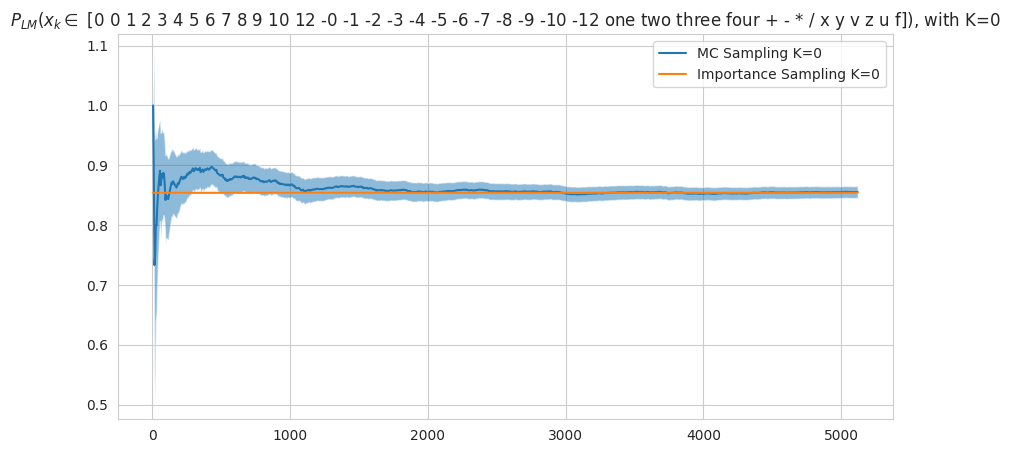

In [42]:
k = 0
## convergence of the algorithm as a function of the number of samples
prob_marginals_IS = marginals_results_is.probs[k]
prob_marginals_MC = marginals_results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_marginals_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_marginals_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
    title="$P_{LM}(x_k \in$ [" + estimate_marginals_kwargs["terms"] +f"]$)$, with K={k}"
)

In [51]:
sampler_is.decode(marginals_results_is.samples)

[' -8*i + 5*z, 0 = -3*z + 2*i + 111. Suppose -8*m = -31 + 21. Calculate m*u(t) + z*g(t).\n5',
 ' 3*n. Let p = n - 3. Find n, given that p = 153981/11 - 14885.\n-3/11\nSuppose 3*i = 205574 - 43832656. What is',
 ' 0. Is 6 bigger than 35?\nTrue\nLet r = 332 + -342. Suppose -r = 9. Which is smaller: -5 or 5?\n5\nLet w(k) = 3*k**2 - 17',
 ' 0. Calculate the highest common divisor of g and 30.\n15\nSuppose 105 = 106*v - 104*v + h, -2*v = -h - 36. Suppose -2*q + 20 =',
 ' -13. Solve y = -0*y - 3*s - 23, 0 = y - s + 3 for y.\n-4\nLet o be (-24)/2*6/12. Suppose o = 5*a',
 ' -m*q for q.\n2\nLet m(g) = -6*g + 51. Let o be m(12). Suppose 23*w = o*w + 3528. Solve -m*l - w',
 ' i, give c.\n-5, 1\nLet c = -95.1 - 103. Let m(h) be the first derivative of h**4/6 - h**3/3 + 7*h**2/2',
 ' -3*r. Let n(f) = -5*f**2 + 20. What is n(r)?\n102\nLet z(y) = y**2 - 9*y - 14. Suppose 0 = 1 +',
 ' 7*a - 7*a for a.\n5\nSolve -109*n + 58*n = -1156 for n.\n-4\nSolve -566 = 17*m - 8*m for m.',
 ' v - v. What is v*h**4

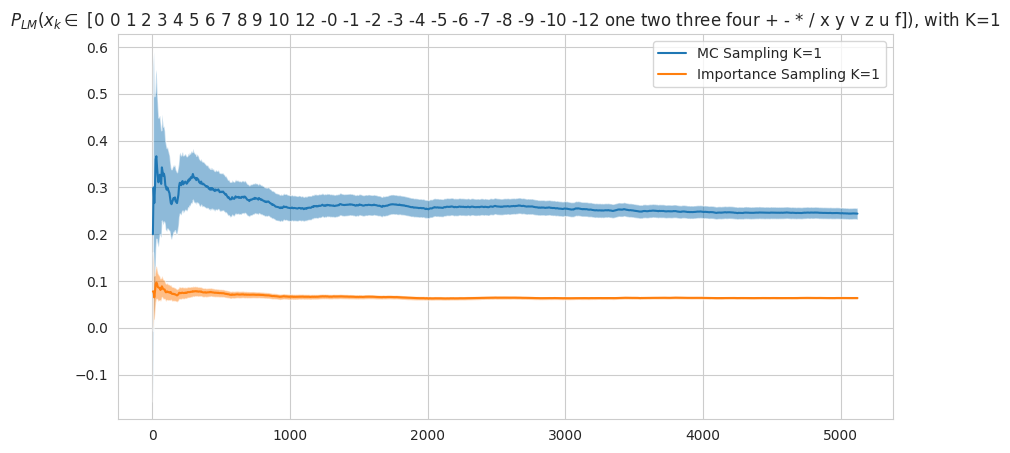

In [48]:
k = 1
## convergence of the algorithm as a function of the number of samples
prob_marginals_IS = marginals_results_is.probs[k]
prob_marginals_MC = marginals_results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_marginals_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_marginals_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
    title="$P_{LM}(x_k \in$ [" + estimate_marginals_kwargs["terms"] +f"]$)$, with K={k}"
)

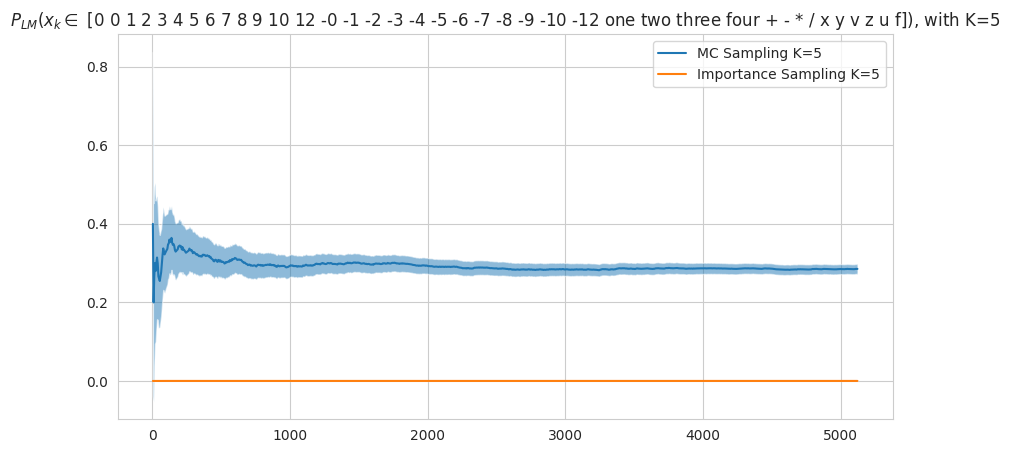

In [49]:
k = 5
## convergence of the algorithm as a function of the number of samples
prob_marginals_IS = marginals_results_is.probs[k]
prob_marginals_MC = marginals_results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_marginals_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_marginals_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
    title="$P_{LM}(x_k \in$ [" + estimate_marginals_kwargs["terms"] +f"]$)$, with K={k}"
)

In [ ]:
k = 15
## convergence of the algorithm as a function of the number of samples
prob_marginals_IS = marginals_results_is.probs[k]
prob_marginals_MC = marginals_results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_marginals_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_marginals_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
    title="$P_{LM}(x_k \in$ [" + estimate_marginals_kwargs["terms"] +f"]$)$, with K={k}"
)

In [ ]:
k = 25
## convergence of the algorithm as a function of the number of samples
prob_marginals_IS = marginals_results_is.probs[k]
prob_marginals_MC = marginals_results_mc.probs[k]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_marginals_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_marginals_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=[f"MC Sampling K={k}", f"Importance Sampling K={k}"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
    title="$P_{LM}(x_k \in$ [" + estimate_marginals_kwargs["terms"] +f"]$)$, with K={k}"
)

### compute confidence interval per timestep

In [ ]:
for i in range(50, 1000, 100):
    is_probs = [p[:i,:] for p in marginals_results_is.probs]
    mc_probs = [p[:i,:] for p in marginals_results_mc.probs]

    is_mean, is_std = sampler_is.compute_confidence_intervals(is_probs, width=2)
    mc_mean, mc_std = sampler_mc.compute_confidence_intervals(mc_probs, width=2)
    
    
    barplot_ncol(
        values=[is_mean, mc_mean],
        stds=[is_std, mc_std],
        titles=[f"Importance Sampling ({i} samples, avg σ ={round(np.mean(is_std), 4)})", f"MC Sampling ({i} samples, avg σ ={round(np.mean(mc_std), 4)})"],
        figsize=(20, 8)
    )

In [ ]:
width = 2

for i in range(50, 1000, 100):
    is_probs = [p[:i,:] for p in marginals_results_is.probs]
    mc_probs = [p[:i,:] for p in marginals_results_mc.probs]

    is_mean, is_std = sampler_is.compute_confidence_intervals(is_probs, width=2)
    mc_mean, mc_std = sampler_mc.compute_confidence_intervals(mc_probs, width=2)
    
    ax = sns.lineplot(x=np.arange(len(is_mean)), y=is_mean, label="Importance Sampling")
    cis = [(mean - width * std, mean + width * std) for mean, std in zip(is_mean, is_std)]
    ax.fill_between(np.arange(len(is_mean)), *zip(*cis), alpha=0.5)

    ax = sns.lineplot(x=np.arange(len(mc_mean)), y=mc_mean, label="MC Sampling")
    cis = [(mean - width * std, mean + width * std) for mean, std in zip(mc_mean, mc_std)]
    ax.fill_between(np.arange(len(mc_mean)), *zip(*cis), alpha=0.5)

    
    plt.title(f"Number of samples: {i}")
    plt.show()

## Co-occurrence probability

In [ ]:
256 * 80

In [ ]:
NUM_SEQUENCES = 20480

estimate_co_occur_kwargs = {
    "input_str": None,
    "terms_A": "nurse",
    "terms_B": " he",
        
    "num_sequences": NUM_SEQUENCES,
    "batch_size": 256, # 
    "max_num_tokens": 50,
    "seed": 97163,
}

results_mc = sampler_mc.batch_estimate_co_occurrence(**estimate_co_occur_kwargs)

In [ ]:
results_mc.probs[0].any()

## hit_probability

In [ ]:
estimate_not_occur_kwargs

In [ ]:
### convergence of the algorithm



### compute confidence interval per timestep

### convergence of the algorithm

### compute confidence interval per timestep